# Algorithmic trading with Keras

The goal of this notebook is to provide the necessary notions to perform time-series forecasting on financial data using the library Keras for Deep Learning. In particular, we will use two models involving LSTM recurrent neural networks and 1-dimensional convolutions to develop an investment strategy for the S&P 500 index.

We will test that, in a period of 4 years which includes the 2008 crisis, these deep learning strategies performed far better than the buy and hold strategy (stay always in the market) and the moving average strategy (stay in the market when the current price is greater than the moving average of past 12 months and sell when it becomes smaller). To quantify these performances, we will compute the gross and net yield (considering the tax on capital gain and the fee to the broker at each transaction).

Throughout this notebook we will use the main libraries for machine learning in Python: *Pandas*, *Numpy*, *Scikit-learn*, *Keras* and *Matplotlib*.

**Author:** [Federico Wolenski](https://www.linkedin.com/in/federicowolenski/)

Note: investing in financial markets is very complicated and should only be done by experienced people. The author declines all responsibility for any losses.

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

import keras
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

/home/wole/anaconda3/envs/algo/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.
/home/wole/anaconda3/envs/algo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wole/anaconda3/envs/algo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wole/anaconda3/envs/algo/lib/python3.6/site-packages/tensorflow/python/frame

The notebook is divided in four parts, in which we will learn the following skills:
- [Download and manage financial data](#get_the_data): use *Pandas* to download S&P500 data from Yahoo Finance and manage it, computing the moving averages
- [Define functions to compute gross and net yield](#compute_yield): use *Numpy* to define functions to compute gross and net yields in a clear and vectorized way
- [Define and train the two Deep Learning models](#train_models): use *Scikit-learn* to preprocess the data and define and train the Deep Learning models with *Keras*
- [Define a simple Deep Learning trading strategy and compare it with other ones](#compare): use *Matplotlib* to visualize the data and the portfolio growth

We will keep the investing strategy as simple and effective as possible. First we will forecast the S&P500 index on a monthly base, predicting at the first trading day of each month what will be the value of the index for the next month. Then, at the beginning of each month, based on our prediction, we will decide wether to "stay in the market" (i.e. invest in the index) or not. 

<a id='get_the_data'></a>
## Download and manage financial data

We download the data of the S&P 500 index from Yahoo Finance. Our analysis is monthly-based, and all the decisions are made the first trading day of the month. For this reason, we fix the conventin that *start_date* will always be the first day of a month and *end_date* will always be the last day of a month.

Our analysis will start from 24 months after the month of *start_date*, since we will use the first 24 months to produce the 2-years moving average.

In [2]:
start_date=datetime.datetime(1973, 1, 1)
end_date=datetime.datetime(2011,3,31)

In [3]:
df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
df.drop("Adj Close",axis=1,inplace=True)
print(df.tail())

                   High          Low         Open        Close      Volume
Date                                                                      
2011-03-25  1319.180054  1310.150024  1311.800049  1313.800049  4223740000
2011-03-28  1319.739990  1310.189941  1315.449951  1310.189941  3215170000
2011-03-29  1319.449951  1305.260010  1309.369995  1319.439941  3482580000
2011-03-30  1331.739990  1321.890015  1321.890015  1328.260010  3809570000
2011-03-31  1329.770020  1325.030029  1327.439941  1325.829956  3566270000


We need the list of the first trading day for each month, so we compute it

In [4]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

For each month we need the means of the month, the first trading day of the current month (and its open price) and the first trading day of the next month (and its open price): out models will predict based on these data.

The feature *quot* is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be useful because it gives the variation of the portfolio for the current month.

Finally we add the columns corresponding to the moving averages at 1 and 2 years.

In [5]:
def monthly_df(df):

    dfm=df.resample("M").mean()
    dfm=dfm[:-1] # As we said, we do not consider the month of end_date
    
    dfm["fd_cm"]=first_days[:-1]
    dfm["fd_nm"]=first_days[1:]
    dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
    dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
    dfm["quot"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])
    
    dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
    dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)
    
    dfm=dfm.iloc[24:,:] # we remove the first 24 months, since they do not have the 2-year moving average
    
    return dfm

In [6]:
dfm=monthly_df(df)

print(dfm.head())
print(dfm.tail())

#each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)
print(dfm.loc["1980-03","mv_avg_12"])
print(dfm.loc["1979-03":"1980-02","Open"])
print(dfm.loc["1979-03":"1980-02","Open"].mean())

                 High        Low       Open      Close        Volume  \
Date                                                                   
1975-01-31  73.546817  71.442273  72.240455  72.564091  1.966136e+07   
1975-02-28  80.988421  78.892106  79.838947  80.096842  2.229684e+07   
1975-03-31  84.783500  82.723500  83.698499  83.831999  2.268050e+07   
1975-04-30  85.649999  83.705001  84.544091  84.723182  2.051591e+07   
1975-05-31  91.089047  89.058096  89.921905  90.096190  2.178524e+07   

                fd_cm      fd_nm  fd_cm_open  fd_nm_open      quot  mv_avg_12  \
Date                                                                            
1975-01-31 1975-01-02 1975-02-03   68.650002   76.980003  1.121340  82.952279   
1975-02-28 1975-02-03 1975-03-03   76.980003   81.589996  1.059886  80.960840   
1975-03-31 1975-03-03 1975-04-01   81.589996   83.360001  1.021694  79.826673   
1975-04-30 1975-04-01 1975-05-01   83.360001   87.300003  1.047265  78.672500   
1975-05-3

<a id='compute_yield'></a>
## Define functions to compute gross and net yield

Notice that the gross yield can be computed very easily using the feature *quot* of the dataframe.
In the following function the vector *v* selects which months we are going to stay in the market.

In [7]:
def yield_gross(df,v):
    prod=(v*df["quot"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

We now need to define a function to compute the net yield, considering (as it is by the Italian law) a 26% tax on capital gain and 0.10% commission to the broker at each transaction. Clearly these values can be changed to adapt the function to the tax system of other countries. 

In [8]:
tax_cg=0.26
comm_bk=0.001

The following function will be used to compute the net yield.

Given any vector of zeros and ones as input, *separate_ones* will return the sequence of vectors of groups of adjacent ones and a scalar equal to the number of groups of adjacent ones.

In [9]:
def separate_ones(u):
    
    u_ = np.r_[0,u,0]
    i = np.flatnonzero(u_[:-1] != u_[1:])
    v,w = i[::2],i[1::2]
    if len(v)==0:
        return np.zeros(len(u)),0
    
    n,m = len(v),len(u)
    o = np.zeros(n*m,dtype=int)

    r = np.arange(n)*m
    o[v+r] = 1

    if w[-1] == m:
        o[w[:-1]+r[:-1]] = -1
    else:
        o[w+r] -= 1

    out = o.cumsum().reshape(n,-1)
    return out,n

Let us clarify the befaviour of this function by an example:

In [10]:
u=np.array([0,1,1,0,1,1,1,0,1])

In [11]:
separate_ones(u)

(array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 3)

The following function is the one which we will use to compute the net yield.

Again, the vector v selects which months we are going to stay in the market.

In [12]:
def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=separate_ones(v)
    A=(w*np.array(df["quot"])+(1-w)).prod(axis=1)  # A is the product of each group of ones of 1 for df["quot"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

<a id='train_models'></a>
## Define and train the two Deep Learning models

We will use two deep learning models to forecast the S&P500 index: one, called *model_lstm*, will be composed of LSTM recurrent neural networks and one, called *model_mix*, will be composed of both LSTM and 1-dimensional convolutional layers.

The first step will be to preprocess the financial data we acquired, in particular we will:
- create a window of data: recurrent neural networks take sequences as inputs and we will reshape the data accordingly. In particular we will give in input to the model all data corresponding to the past 6 months 
- scale the financial data in a range from 0 to 1, since recurrent neural networks work best with such data
- divide the data in train and test set: the latter one will be the set on which we will compare the trading strategies. By default we will set this set to be 72 months long.

**Both our models will predict the value of the S&P500 index for the first trading day of the following month, given all data of the past 6 months.**

In [13]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [14]:
def data_to_model(dfm):
    scaler=MinMaxScaler(feature_range=(0,1))
    dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
    X=dg[[0,1,2,3,4,5,6,7]]
    X=create_window(X,window)
    X=np.reshape(X.values,(X.shape[0],window+1,8))
    
    y=np.array(dg[8][window:])
    
    return X,y

The input data for the model will be a tensor of shape 

(# months, window +1, # features)

The output data of the model will be a single vector of length # months

In [15]:
window=5

X,y=data_to_model(dfm)
print(X.shape,y.shape)

(429, 6, 8) (429,)


In [16]:
mtest=72

X_train=X[:-mtest-1,:,:]
X_test=X[-mtest-1:,:,:]
y_train=y[:-mtest-1]
y_test=y[-mtest-1:]

In [17]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False)) # there is no need to specify input_shape here
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model

In [18]:
def model_mix(window,features):
    
    model=Sequential()
    model.add(Conv1D(input_shape=(window,features),filters=32,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(LSTM(300, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model

In [19]:
model_lstm=model_lstm(window+1,8)
print(model_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 300)            370800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 791,801
Trainable params: 791,801
Non-trainable params: 0
_________________________________________________________________
None

We will use the following keras callback to reduce the learning rate as the training progresses.

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=25, verbose=1,\
                                                 factor=0.25, min_lr=0.00001)

Here we can start the training for 400 epochs

In [21]:
history_lstm=model_lstm.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Train on 356 samples, validate on 73 samples
Epoch 1/400
356/356 [==============================] - 3s 7ms/step - loss: 0.0261 - val_loss: 0.0118
Epoch 2/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0623 - val_loss: 0.0909
Epoch 3/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0274
Epoch 4/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0193
Epoch 5/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0764
Epoch 6/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0654 - val_loss: 0.0781
Epoch 7/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0633
Epoch 8/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0651 - val_loss: 0.1066
Epoch 9/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0302
Epoch 10/400
356/356 [========================

Epoch 81/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0077
Epoch 82/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0145
Epoch 83/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0075
Epoch 84/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0129
Epoch 85/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 86/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0133
Epoch 87/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 88/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0135
Epoch 89/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 90/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0069

356/356 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0116
Epoch 161/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 162/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0150
Epoch 163/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 164/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0127
Epoch 165/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 166/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 167/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 168/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0065
Epoch 169/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0024 - v

Epoch 239/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 240/400
356/356 [==============================] - 1s 2ms/step - loss: 9.3169e-04 - val_loss: 0.0055
Epoch 241/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 242/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 243/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 244/400
356/356 [==============================] - 1s 2ms/step - loss: 8.8770e-04 - val_loss: 0.0052
Epoch 245/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 246/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 247/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 248/400
356/356 [==============================] - 1s 2ms/s

Epoch 314/400
356/356 [==============================] - 1s 2ms/step - loss: 9.6498e-04 - val_loss: 0.0060
Epoch 315/400
356/356 [==============================] - 1s 2ms/step - loss: 8.2778e-04 - val_loss: 0.0060
Epoch 316/400
356/356 [==============================] - 1s 2ms/step - loss: 9.0717e-04 - val_loss: 0.0059
Epoch 317/400
356/356 [==============================] - 1s 2ms/step - loss: 7.3695e-04 - val_loss: 0.0059
Epoch 318/400
356/356 [==============================] - 1s 2ms/step - loss: 9.4174e-04 - val_loss: 0.0059
Epoch 319/400
356/356 [==============================] - 1s 2ms/step - loss: 8.7964e-04 - val_loss: 0.0059
Epoch 320/400
356/356 [==============================] - 1s 2ms/step - loss: 8.6996e-04 - val_loss: 0.0060
Epoch 321/400
356/356 [==============================] - 1s 2ms/step - loss: 8.9122e-04 - val_loss: 0.0060
Epoch 322/400
356/356 [==============================] - 1s 2ms/step - loss: 7.5467e-04 - val_loss: 0.0061
Epoch 323/400
356/356 [==============

356/356 [==============================] - 1s 2ms/step - loss: 8.9189e-04 - val_loss: 0.0062
Epoch 391/400
356/356 [==============================] - 1s 2ms/step - loss: 8.0342e-04 - val_loss: 0.0062
Epoch 392/400
356/356 [==============================] - 1s 2ms/step - loss: 7.9491e-04 - val_loss: 0.0063
Epoch 393/400
356/356 [==============================] - 1s 2ms/step - loss: 8.7565e-04 - val_loss: 0.0063
Epoch 394/400
356/356 [==============================] - 1s 2ms/step - loss: 7.7100e-04 - val_loss: 0.0063
Epoch 395/400
356/356 [==============================] - 1s 2ms/step - loss: 6.4816e-04 - val_loss: 0.0063
Epoch 396/400
356/356 [==============================] - 1s 2ms/step - loss: 9.2238e-04 - val_loss: 0.0064
Epoch 397/400
356/356 [==============================] - 1s 2ms/step - loss: 8.3565e-04 - val_loss: 0.0065
Epoch 398/400
356/356 [==============================] - 1s 2ms/step - loss: 8.1334e-04 - val_loss: 0.0066
Epoch 399/400
356/356 [============================

In the following plot we can visualize the train and test losses as the training progresses

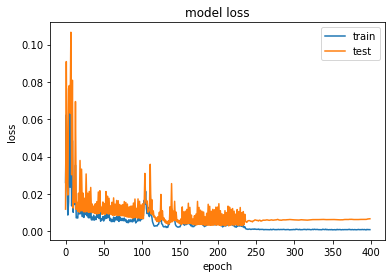

In [22]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [23]:
model_lstm.save_weights("lstm_weights.h5")

In [24]:
model_mix=model_mix(window+1,8)
print(model_mix.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 32)             544       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 64)             4160      
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 300)            438000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
__________

Here we can start the training for 400 epochs

In [25]:
history_mix=model_mix.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Train on 356 samples, validate on 73 samples
Epoch 1/400
356/356 [==============================] - 2s 7ms/step - loss: 0.0288 - val_loss: 0.0121
Epoch 2/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0619 - val_loss: 0.0654
Epoch 3/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0374 - val_loss: 0.0423
Epoch 4/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0132
Epoch 5/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0151
Epoch 6/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.1219
Epoch 7/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0493 - val_loss: 0.0065
Epoch 8/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0616 - val_loss: 0.2305
Epoch 9/400
356/356 [==============================] - 1s 2ms/step - loss: 0.1115 - val_loss: 0.3533
Epoch 10/400
356/356 [========================

356/356 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0092
Epoch 80/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 81/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 82/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0082

Epoch 00082: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 83/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0084
Epoch 84/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0085
Epoch 85/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0085
Epoch 86/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 87/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0087
Epoch 88/400


356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 158/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0089
Epoch 159/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0088
Epoch 160/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0087
Epoch 161/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 162/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0088
Epoch 163/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0089
Epoch 164/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 165/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0090
Epoch 166/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - v

356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0094
Epoch 237/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0095
Epoch 238/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0096
Epoch 239/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 240/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0098
Epoch 241/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0099
Epoch 242/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0098
Epoch 243/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 244/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0092
Epoch 245/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - v

356/356 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0096
Epoch 316/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0097
Epoch 317/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0096
Epoch 318/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0098
Epoch 319/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0099
Epoch 320/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0094
Epoch 321/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0089
Epoch 322/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0089
Epoch 323/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 324/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0015 - v

356/356 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0093
Epoch 395/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0096
Epoch 396/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0098
Epoch 397/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0098
Epoch 398/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0092
Epoch 399/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0083
Epoch 400/400
356/356 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0081


In the following plot we can visualize the train and test losses as the training progresses

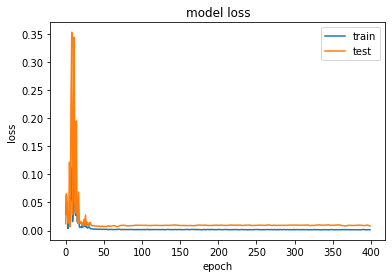

In [26]:
plt.plot(history_mix.history['loss'])
plt.plot(history_mix.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [27]:
model_mix.save_weights("mix_weights.h5")

In [28]:
y_pred_train_lstm=model_lstm.predict(X_train)
y_pred_train_mix=model_mix.predict(X_train)

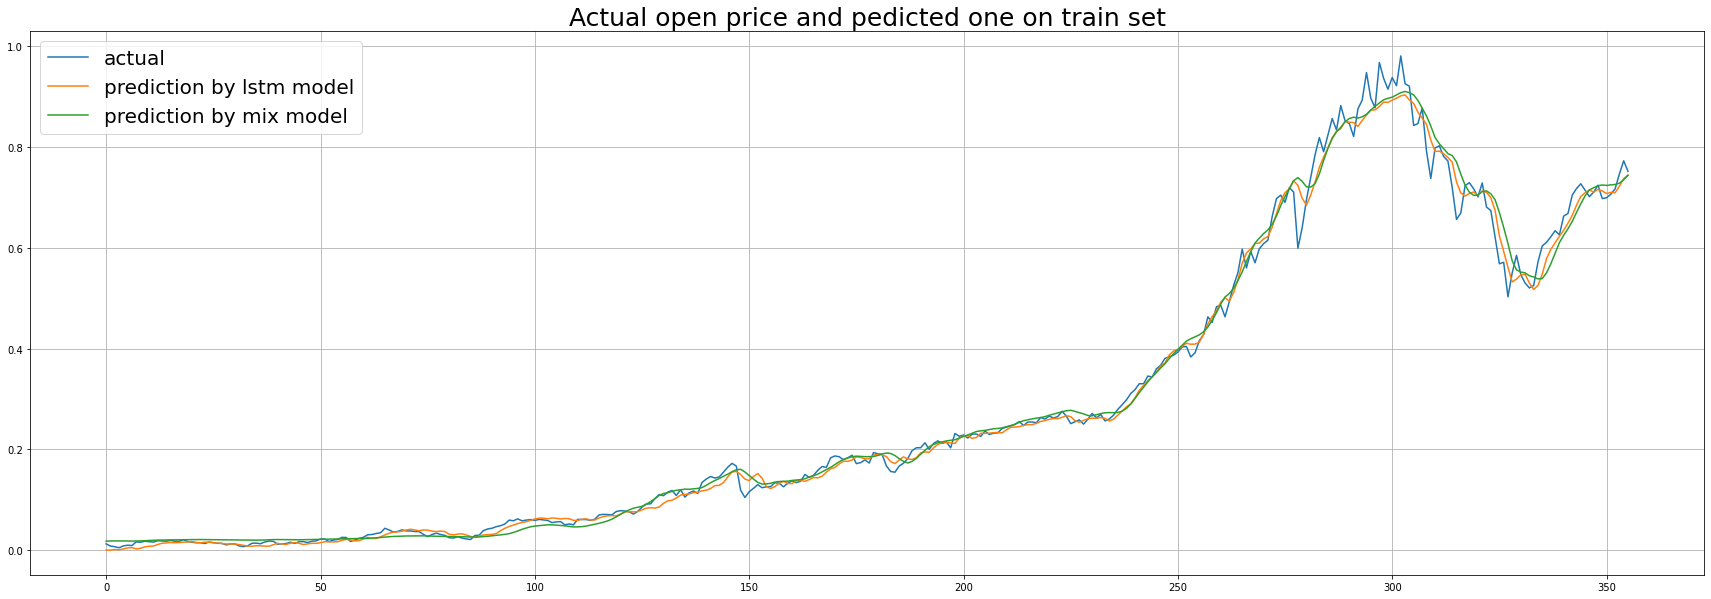

In [29]:
plt.figure(figsize=(30,10))
plt.plot(y_train, label="actual")
plt.plot(y_pred_train_lstm, label="prediction by lstm model")
plt.plot(y_pred_train_mix, label="prediction by mix model")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

<a id='compare'></a>
## Define a simple Deep Learning trading strategy and compare it with other ones

Now that we have defined and trained our deep learning forecasting models, we can develop our investing strategy.
The first thing to do will be to predict the value of the S%P500 index for the next month on the test-set.

In [30]:
y_pred_lstm=model_lstm.predict(X_test)
y_pred_mix=model_mix.predict(X_test)

Our trading strategy will be the simplest one possible: 

**We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vectors v indicate the "in months" (as 1s) and "out months" (as 0s)**

In [31]:
w_lstm=np.diff(y_pred_lstm.reshape(y_pred_lstm.shape[0]),1)
v_lstm=np.maximum(np.sign(w_lstm),0)

w_mix=np.diff(y_pred_mix.reshape(y_pred_mix.shape[0]),1)
v_mix=np.maximum(np.sign(w_mix),0)

Here we plot the in and out months for each month in the test-set.

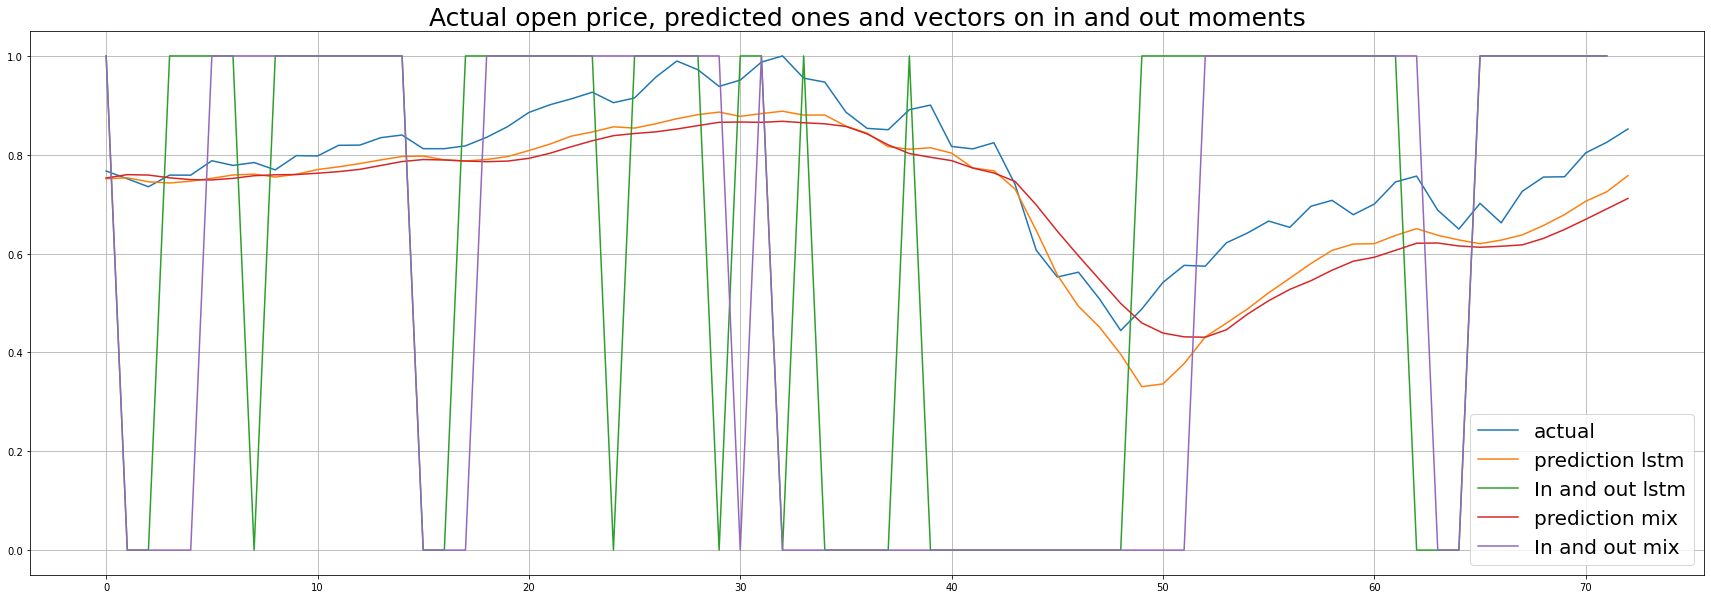

In [32]:
plt.figure(figsize=(30,10))
plt.plot(y_test, label="actual")
plt.plot(y_pred_lstm, label="prediction lstm")
plt.plot(v_lstm,label="In and out lstm")
plt.plot(y_pred_mix, label="prediction mix")
plt.plot(v_mix,label="In and out mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted ones and vectors on in and out moments",fontsize=25)
plt.show()

**The preceeding plot shows an interesting feature of the prediction of our models: they are quite good at predicting the sign of the first derivative of the index, and this is exactly what we need for our trading strategy!** 

Now we can compare our deep learning trading strategies with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [33]:
test=dfm.iloc[-mtest:,:] 
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [34]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["quot"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

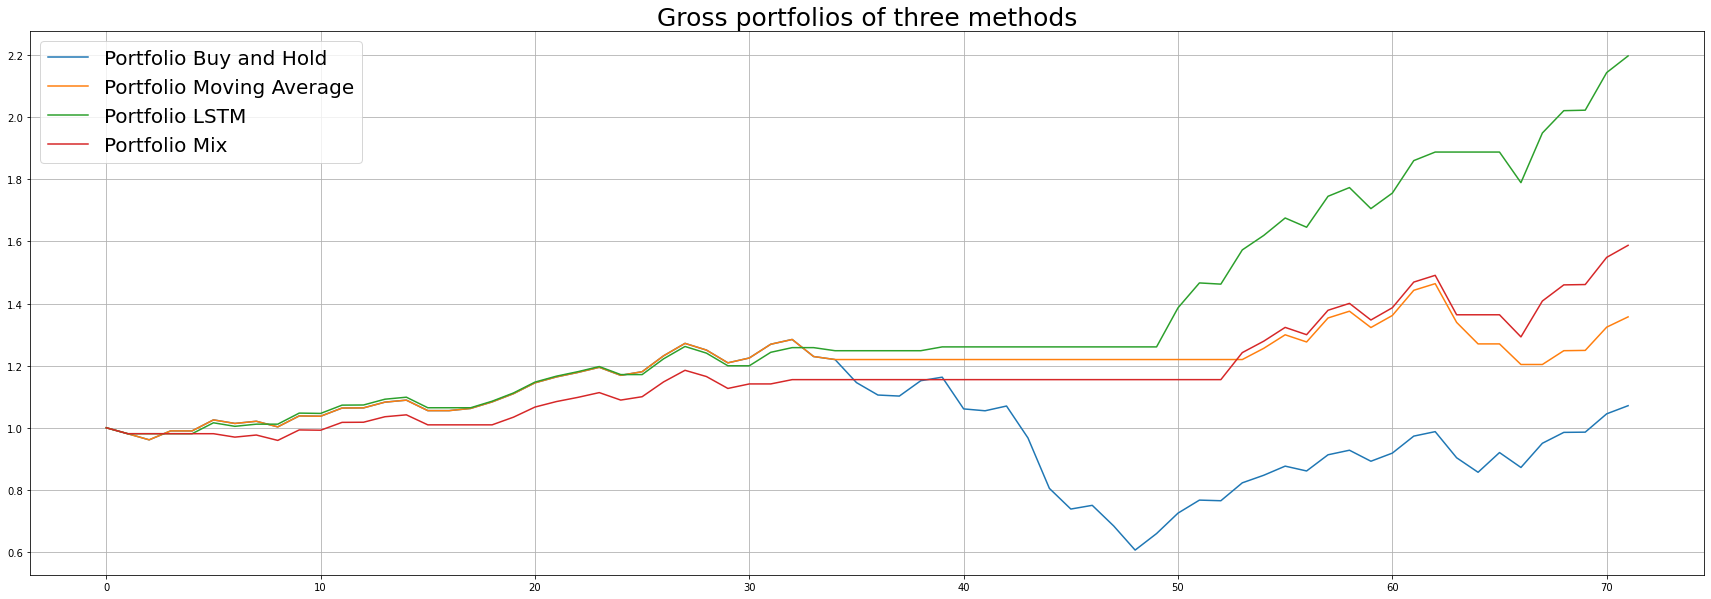

In [35]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.plot(gross_portfolio(test,v_mix),label="Portfolio Mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

Finally, we can see that our deep learning investing strategies performed on the test-set far better than the other two classical investing strategies.

In [36]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results=pd.DataFrame({})
results["Method"]=["Buy and hold","Moving average","LSTM","Mix"]

vs=[v_bh,v_ma,v_lstm,v_mix]
results["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results)

Test period of 6.00 years, from 2005-03-01 to 2011-03-01 

           Method Total gross yield Annual gross yield Total net yield  \
0    Buy and hold           10.39 %             1.66 %          7.47 %   
1  Moving average           39.86 %             5.75 %         26.14 %   
2            LSTM          126.46 %            14.59 %         81.67 %   
3             Mix            63.6 %             8.55 %         42.54 %   

  Annual net yield  
0           1.21 %  
1           3.95 %  
2          10.46 %  
3           6.09 %  


In [41]:
print(len(v_lstm),len(np.array(test["quot"])))
tt=np.array(test["quot"])

72 72


In [43]:
q1=(v_lstm[:12]*tt[:12]).prod()
print(q1)

0.0


In [44]:
print(v_lstm[:12])

[1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.]


In [45]:
print(tt[:12])

[0.98088234 0.97989142 1.02995205 0.99985729 1.03596829 0.9887779
 1.00694902 0.98225922 1.0351861  0.99904765 1.02546677 1.00045316]


In [50]:
print(tt[:12]*v_lstm[:12])
print(tt[:12]*v_lstm[:12]+1)
print(tt[:12]*v_lstm[:12]+1-v_lstm[:12])
print((tt[:12]*v_lstm[:12]+1-v_lstm[:12]).prod())

[0.98088234 0.         0.         0.99985729 1.03596829 0.9887779
 1.00694902 0.         1.0351861  0.99904765 1.02546677 1.00045316]
[1.98088234 1.         1.         1.99985729 2.03596829 1.9887779
 2.00694902 1.         2.0351861  1.99904765 2.02546677 2.00045316]
[0.98088234 1.         1.         0.99985729 1.03596829 0.9887779
 1.00694902 1.         1.0351861  0.99904765 1.02546677 1.00045316]
1.0733234386103938


In [51]:
print((tt[12:24]*v_lstm[12:24]+1-v_lstm[12:24]).prod())

1.0912102096655218


In [52]:
print((tt[24:36]*v_lstm[24:36]+1-v_lstm[24:36]).prod())

1.0656227610652687


In [53]:
print((tt[36:48]*v_lstm[36:48]+1-v_lstm[36:48]).prod())

1.0098487158470957


In [54]:
print((tt[48:60]*v_lstm[48:60]+1-v_lstm[48:60]).prod())

1.3928602275049458


In [55]:
print((tt[60:72]*v_lstm[60:72]+1-v_lstm[60:72]).prod())

1.2899607047103012
